In [2]:
import math
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

X_train = trainset.data[:]
y_train = trainset.targets

X_test = testset.data[:]
y_test = testset.targets

Files already downloaded and verified
Files already downloaded and verified


In [5]:
y_train = np.asarray(y_train, dtype=np.int32)
y_test = np.asarray(y_test, dtype=np.int32)

In [6]:
# encode the labels
num_classes = len(classes)
num_inputs = y_train.shape[0]
y_train = y_train.reshape(1, num_inputs)
y_train_new = np.eye(num_classes)[y_train.astype('int32')]
y_train_new = y_train_new.T.reshape(num_classes, num_inputs)

num_inputs = y_test.shape[0]
y_test = y_test.reshape(1, num_inputs)
y_test_new = np.eye(num_classes)[y_test.astype('int32')]
y_test_new = y_test_new.T.reshape(num_classes, num_inputs)

X_train_new = np.reshape(X_train, (-1, 3072))
X_test_new = np.reshape(X_test, (-1, 3072))

In [7]:
X_train_new = X_train_new[:]/ 255.0
X_test_new = X_test_new[:]/ 255.0

In [15]:
accuracy = k_fold_validation(X_train_new, y_train_new)
accuracy

Epoch 1: training loss = 2.1167010536286477
Epoch 2: training loss = 2.071828989562948
Epoch 3: training loss = 2.0670538917839196
Epoch 4: training loss = 2.052666961109799
Epoch 5: training loss = 2.0451518542544576
Epoch 6: training loss = 2.0680881672761613
Epoch 7: training loss = 2.0770407036834526
Epoch 8: training loss = 2.0246100128504487
Epoch 9: training loss = 2.017428194116332
Epoch 10: training loss = 1.9936817609243804
Epoch 11: training loss = 2.0139438751365977
Epoch 12: training loss = 1.9952437056689214
Epoch 13: training loss = 2.012551242173144
Epoch 14: training loss = 1.9805124749767817
Epoch 15: training loss = 1.9920867512397447
Epoch 16: training loss = 2.0038889222876675
Epoch 17: training loss = 1.9879121967012445
Epoch 18: training loss = 1.9867350990755372
Epoch 19: training loss = 2.0244623657066594
Epoch 20: training loss = 2.00145468459944
Epoch 21: training loss = 1.9935534731213826
Epoch 22: training loss = 2.000263549852762
Epoch 23: training loss = 

[0.2252, 0.219, 0.2293, 0.224, 0.2303]

In [8]:
def k_fold_validation(X, y, k=5, h1=2, h2=2, lr=0.5, batch_size=200, epochs=50, f1="logistic", f2="logistic"):
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y.T, k)
    accuracy = []
    
    for i in range(k):
        X_train = X_folds.copy()
        X_test = X_folds[i]
        
        y_train = y_folds.copy()
        y_test = y_folds[i].T
        
        del X_train[i]
        del y_train[i]
        
        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train).T
        
        #model = MLP_2H(h1,h2)
        model = MLP(h1)
        model.train(X_train, y_train, lr, batch_size, epochs, f1)
        accuracy.append(model.test(X_test, y_test))
        
    return np.average(accuracy)

### Multi Layer Perceptron with 1 Hidden Layer. 

In [9]:
class MLP:
    
    def __init__(self, h_num):
        # initialization
        self.w1 = np.random.randn(h_num, 3072) * np.sqrt(1. / 3072)
        self.b1 = np.zeros((h_num, 1)) * np.sqrt(1. / 3072)
        self.w2 = np.random.randn(num_classes, h_num) * np.sqrt(1. / 3072)
        self.b2 = np.zeros((num_classes, 1)) * np.sqrt(1. / 3072)
        
    def train(self, X_train, y_train, lr=0.5, batch_size=200, epochs=50, f1="logistic", f2="logistic"):
        batches = math.ceil(X_train.shape[0] / batch_size)
        self.f1 = f1
        self.f2 = f2
            
        for epoch in range(epochs):
            for batch in range(batches):
                begin = batch * batch_size
                end = min(begin + batch_size, X_train.shape[0] - 1)
                X = X_train[begin:end, :]
                y = y_train[:, begin:end]
                m_batch = end - begin
    
                if m_batch == 0:
                    continue
    
                # forward and backward
                self.feed_forward(X)
                self.back_propagate(X, y, m_batch)
                
                # gradient descent
                self.w1 = self.w1 - lr * self.d_w1
                self.b1 = self.b1 - lr * self.d_b1
                self.w2 = self.w2 - lr * self.d_w2
                self.b2 = self.b2 - lr * self.d_b2
                
            # forward pass on training set
            self.feed_forward(X_train)
            train_loss = self.loss_fucntion(y_train, self.a2)
            print("Epoch {}: training loss = {}".format(epoch + 1, train_loss))
            
    def test(self, X_test, y_test):
        self.feed_forward(X_test)
        return self.accuracy(y_test, self.a2)
    
    def feed_forward(self, X):        
        self.z1 = np.matmul(self.w1, X.T) + self.b1
        
        if self.f1 == 'logistic':
            self.a1 = self.logistic(self.z1)
        else:
            self.a1 = self.relu(self.z1)
        
        self.z2 = np.matmul(self.w2, self.a1) + self.b2
        
        self.a2 = np.exp(self.z2) / np.sum(np.exp(self.z2), axis=0)
        
    def back_propagate(self, X, y, m_batch):
        self.d_z2 = self.a2 - y
        
        self.d_w2 = (1. / m_batch) * np.matmul(self.d_z2, self.a1.T)
        self.d_b2 = (1. / m_batch) * np.sum(self.d_z2, axis=1, keepdims=True)
        
        self.d_a1 = np.matmul(self.w2.T, self.d_z2)

        if self.f1 == 'logistic':
            self.d_z1 = self.d_a1 * self.logistic(self.z1) * (1 - self.logistic(self.z1))
        else: 
            self.d_z1 = self.d_relu(self.d_a1, self.z1)
        
        self.d_w1 = (1. / m_batch) * np.matmul(self.d_z1, X)
        self.d_b1 = (1. / m_batch) * np.sum(self.d_z1, axis=1, keepdims=True)
        
    def accuracy(self, y, y_h):
        y_test = (y_h.T == y_h.T.max(axis=1)[:, None]).astype(int)
        y_h = y_test
        y = y.T 
        
        true_labels = np.argmax(y, axis=1)
        pred_labels = np.argmax(y_h, axis=1)
        
        return np.mean(true_labels == pred_labels)
    
    def d_relu(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0;
        return dZ;
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def logistic(self, x):
        return 1.0/(1 + np.exp(-x))
    
    def loss_fucntion(self, y, y_h):
        L_sum = np.sum(np.multiply(y, np.log(y_h)))
        m = y.shape[1]
        return -(1./m) * L_sum

### Multi Layer Perceptron with 2 Hidden Layers.

In [8]:
class MLP_2H:
    
    def __init__(self, h1_num, h2_num):
        # initialization
        self.w1 = np.random.randn(h1_num, 3072) * np.sqrt(1. / 3072)
        self.b1 = np.zeros((h1_num, 1)) * np.sqrt(1. / 3072)
        
        self.w2 = np.random.randn(h2_num, h1_num) * np.sqrt(1. / 3072)
        self.b2 = np.zeros((h2_num, 1)) * np.sqrt(1. / 3072)
        
        self.w3 = np.random.randn(num_classes, h2_num) * np.sqrt(1. / 3072)
        self.b3 = np.zeros((num_classes, 1)) * np.sqrt(1. / 3072)
        
    def train(self, X_train, y_train, lr=0.5, batch_size=64, epochs=100, f1="logistic", f2="logistic"):
        batches = math.ceil(X_train.shape[0] / batch_size)
        self.f1 = f1
        self.f2 = f2
        
        for epoch in range(epochs):
            for batch in range(batches):
                # get mini-batch
                begin = batch * batch_size
                end = min(begin + batch_size, X_train.shape[0] - 1)
                X = X_train[begin:end, :]
                y = y_train[:, begin:end]
                m_batch = end - begin
    
                if m_batch == 0:
                    continue
    
                # forward and backward
                self.feed_forward(X)
                self.back_propagate(X, y, m_batch)
                
                # gradient descent
                self.w1 = self.w1 - lr * self.d_w1
                self.b1 = self.b1 - lr * self.d_b1
                self.w2 = self.w2 - lr * self.d_w2
                self.b2 = self.b2 - lr * self.d_b2
                self.w3 = self.w3 - lr * self.d_w3
                self.b3 = self.b3 - lr * self.d_b3
                
            # forward pass on training set
            self.feed_forward(X_train)
            train_loss = self.loss_fucntion(y_train, self.a3)
            print("Epoch {}: training loss = {}".format(epoch + 1, train_loss))
            
    def test(self, X_test, y_test):
        self.feed_forward(X_test)
        return self.accuracy(y_test, self.a3)
    
    def feed_forward(self, X):
        self.z1 = np.matmul(self.w1, X.T) + self.b1
        
        if self.f1 == 'logistic':
            self.a1 = self.logistic(self.z1)
        else:
            self.a1 = self.relu(self.z1)
        
        self.z2 = np.matmul(self.w2, self.a1) + self.b2
    
        if self.f2 == 'logistic':
            self.a2 = self.logistic(self.z2)
        else:
            self.a2 = self.relu(self.z2)
            
        self.z3 = np.matmul(self.w3, self.a2) + self.b3
        
        self.a3 = np.exp(self.z3) / np.sum(np.exp(self.z3), axis=0)
        
    def back_propagate(self, X, y, m_batch):
        self.d_z3 = self.a3 - y
        
        self.d_w3 = (1. / m_batch) * np.matmul(self.d_z3, self.a2.T)
        self.d_b3 = (1. / m_batch) * np.sum(self.d_z3, axis=1, keepdims=True)
        
        self.d_a2 = np.matmul(self.w3.T, self.d_z3)
        
        if self.f2 == 'logistic':
            self.d_z2 = self.d_a2 * self.logistic(self.z2) * (1 - self.logistic(self.z2))
        else:
            self.d_z2 = self.d_relu(self.d_a2, self.z2)
        
        self.d_w2 = (1. / m_batch) * np.matmul(self.d_z2, self.a1.T)
        self.d_b2 = (1. / m_batch) * np.sum(self.d_z2, axis=1, keepdims=True)
        
        self.d_a1 = np.matmul(self.w2.T, self.d_z2)
        if self.f1 == 'logistic':
            self.d_z1 = self.d_a1 * self.logistic(self.z1) * (1 - self.logistic(self.z1))
        else:
            self.d_z1 = self.d_relu(self.d_a1, self.z1)

        self.d_w1 = (1. / m_batch) * np.matmul(self.d_z1, X)
        self.d_b1 = (1. / m_batch) * np.sum(self.d_z1, axis=1, keepdims=True)
        
    def accuracy(self, y, y_h):
        y_test = (y_h.T == y_h.T.max(axis=1)[:, None]).astype(int)
        y_h = y_test
        y = y.T 
        
        true_labels = np.argmax(y, axis=1)
        pred_labels = np.argmax(y_h, axis=1)
        
        return np.mean(true_labels == pred_labels)
    
    def d_relu(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0;
        return dZ;
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def logistic(self, x):
        return 1.0/(1 + np.exp(-x))
    
    def loss_fucntion(self, y, y_h):
        L_sum = np.sum(np.multiply(y, np.log(y_h)))
        m = y.shape[1]
        return -(1./m) * L_sum

### Testing

In [16]:
k_fold_validation(X_train_new, y_train_new)


Epoch 1: training loss = 2.1442439983158077
Epoch 2: training loss = 2.0721665463577987
Epoch 3: training loss = 2.0651841951647913
Epoch 4: training loss = 2.0242909617746645
Epoch 5: training loss = 2.0196156886837557
Epoch 6: training loss = 2.074393573431197
Epoch 7: training loss = 2.0047769620247293
Epoch 8: training loss = 2.0303339848149795
Epoch 9: training loss = 2.0297884569698
Epoch 10: training loss = 1.9907107885335602
Epoch 11: training loss = 2.0136865801883825
Epoch 12: training loss = 2.043388115427495
Epoch 13: training loss = 2.0177586781177217
Epoch 14: training loss = 2.015662877762566
Epoch 15: training loss = 2.0125817768594985
Epoch 16: training loss = 2.025714959357471
Epoch 17: training loss = 2.006207018467881
Epoch 18: training loss = 2.0111330279322077
Epoch 19: training loss = 1.999049191938128
Epoch 20: training loss = 2.0029937037392456
Epoch 21: training loss = 2.003239792054866
Epoch 22: training loss = 1.9978189113107359
Epoch 23: training loss = 1.9

[0.2296, 0.2225, 0.234, 0.2401, 0.23]

In [18]:
test_name = []
test_acc = []

In [19]:
units = [5,10,15,20]
batch = [50,100,150,200]


In [22]:
for i in units:
    for j in batch:
        test_acc.append(k_fold_validation(X_train_new, y_train_new,h1=i,batch_size=j))
test_acc

Epoch 1: training loss = 1.9639382664939935
Epoch 2: training loss = 1.9503470593707815
Epoch 3: training loss = 1.9204747119518122
Epoch 4: training loss = 1.9186893947755708
Epoch 5: training loss = 1.9047551216543144
Epoch 6: training loss = 1.8797099206932726
Epoch 7: training loss = 1.8755147111102801
Epoch 8: training loss = 1.8785442993372956
Epoch 9: training loss = 1.8418003873405138
Epoch 10: training loss = 1.8584059461548508
Epoch 11: training loss = 1.876056485781294
Epoch 12: training loss = 1.8720413443353632
Epoch 13: training loss = 1.847093695690106
Epoch 14: training loss = 1.8367699902206271
Epoch 15: training loss = 1.8565720965061168
Epoch 16: training loss = 1.8477599501381659
Epoch 17: training loss = 1.8433832381645765
Epoch 18: training loss = 1.8482761940922106
Epoch 19: training loss = 1.8616297494949399
Epoch 20: training loss = 1.8359032790170438
Epoch 21: training loss = 1.8467516666160704
Epoch 22: training loss = 1.8286909695264284
Epoch 23: training lo

Epoch 17: training loss = 1.8597330862318224
Epoch 18: training loss = 1.8479263554672192
Epoch 19: training loss = 1.8287783267839277
Epoch 20: training loss = 1.8539485497811878
Epoch 21: training loss = 1.8481812578342474
Epoch 22: training loss = 1.8314525606515495
Epoch 23: training loss = 1.8441635255716928
Epoch 24: training loss = 1.8270643331179006
Epoch 25: training loss = 1.8207330239137727
Epoch 26: training loss = 1.8209684077004455
Epoch 27: training loss = 1.8225919564660207
Epoch 28: training loss = 1.8022919416838985
Epoch 29: training loss = 1.8454510761439762
Epoch 30: training loss = 1.8143671366951273
Epoch 31: training loss = 1.816984079166608
Epoch 32: training loss = 1.8171917870919567
Epoch 33: training loss = 1.8049535526767173
Epoch 34: training loss = 1.8086353480635096
Epoch 35: training loss = 1.8100947584793963
Epoch 36: training loss = 1.8226288385342257
Epoch 37: training loss = 1.8182424657046425
Epoch 38: training loss = 1.8188035824106328
Epoch 39: t

Epoch 33: training loss = 1.8600956133703592
Epoch 34: training loss = 1.8171735674149325
Epoch 35: training loss = 1.8247596013760774
Epoch 36: training loss = 1.9072529299233738
Epoch 37: training loss = 1.8502913293049654
Epoch 38: training loss = 1.8889471909481739
Epoch 39: training loss = 1.8566888115931537
Epoch 40: training loss = 1.8947396219240353
Epoch 41: training loss = 1.842842649782583
Epoch 42: training loss = 1.8785209645799412
Epoch 43: training loss = 1.8721363540557003
Epoch 44: training loss = 1.8813754566311185
Epoch 45: training loss = 1.8741216771449087
Epoch 46: training loss = 1.8538043273420437
Epoch 47: training loss = 1.8623663243954254
Epoch 48: training loss = 1.8836622071952014
Epoch 49: training loss = 1.8708075228352734
Epoch 50: training loss = 1.8354177518674348
Epoch 1: training loss = 2.0794999693039764
Epoch 2: training loss = 2.0107647608739696
Epoch 3: training loss = 1.9727704457032982
Epoch 4: training loss = 1.9392047832632089
Epoch 5: traini

Epoch 50: training loss = 1.6563423120468104
Epoch 1: training loss = 1.9361641351211836
Epoch 2: training loss = 1.9190709466577778
Epoch 3: training loss = 1.8897003677862751
Epoch 4: training loss = 1.8376441500074774
Epoch 5: training loss = 1.8024986898260793
Epoch 6: training loss = 1.8415626100804916
Epoch 7: training loss = 1.7879479102402966
Epoch 8: training loss = 1.8370676565669264
Epoch 9: training loss = 1.813780168677407
Epoch 10: training loss = 1.7988864433945682
Epoch 11: training loss = 1.7711805078443421
Epoch 12: training loss = 1.7479683849620113
Epoch 13: training loss = 1.7405694009408421
Epoch 14: training loss = 1.7270315271319172
Epoch 15: training loss = 1.7486193013976634
Epoch 16: training loss = 1.7240964015077576
Epoch 17: training loss = 1.7425655365894626
Epoch 18: training loss = 1.717715774448315
Epoch 19: training loss = 1.7321991818226339
Epoch 20: training loss = 1.7138712599055028
Epoch 21: training loss = 1.7450260180652801
Epoch 22: training lo

Epoch 16: training loss = 1.770837621494685
Epoch 17: training loss = 1.8036763719904911
Epoch 18: training loss = 1.7772851211354768
Epoch 19: training loss = 1.7798364174298102
Epoch 20: training loss = 1.7183541211674647
Epoch 21: training loss = 1.71944892967237
Epoch 22: training loss = 1.7345268587144456
Epoch 23: training loss = 1.740235468120988
Epoch 24: training loss = 1.7480954691324577
Epoch 25: training loss = 1.7413668752753195
Epoch 26: training loss = 1.7467703907271543
Epoch 27: training loss = 1.7068423396581367
Epoch 28: training loss = 1.7004353194515713
Epoch 29: training loss = 1.6769855043319823
Epoch 30: training loss = 1.6800675203448951
Epoch 31: training loss = 1.6821759967544536
Epoch 32: training loss = 1.6597965711675196
Epoch 33: training loss = 1.6472054177359148
Epoch 34: training loss = 1.6522161683241492
Epoch 35: training loss = 1.6520591280906636
Epoch 36: training loss = 1.6731509311478694
Epoch 37: training loss = 1.6611876476810712
Epoch 38: trai

Epoch 32: training loss = 1.6741089436962442
Epoch 33: training loss = 1.657968067431575
Epoch 34: training loss = 1.6551819973247552
Epoch 35: training loss = 1.649764071208182
Epoch 36: training loss = 1.6707930626769976
Epoch 37: training loss = 1.6487483770241402
Epoch 38: training loss = 1.6657214214679237
Epoch 39: training loss = 1.6575671272113246
Epoch 40: training loss = 1.6399608947056918
Epoch 41: training loss = 1.6485883851690786
Epoch 42: training loss = 1.6794700760420944
Epoch 43: training loss = 1.6658744583310754
Epoch 44: training loss = 1.6692472062995574
Epoch 45: training loss = 1.6546287866185565
Epoch 46: training loss = 1.6788796293744035
Epoch 47: training loss = 1.6660853800519424
Epoch 48: training loss = 1.682425423254649
Epoch 49: training loss = 1.6393552447481285
Epoch 50: training loss = 1.6434846641706715
Epoch 1: training loss = 2.038421269324818
Epoch 2: training loss = 1.9163377128567254
Epoch 3: training loss = 1.9285143360324197
Epoch 4: training

Epoch 48: training loss = 1.6024352006374893
Epoch 49: training loss = 1.5785233307255577
Epoch 50: training loss = 1.591194372454405
Epoch 1: training loss = 1.9114962032170366
Epoch 2: training loss = 1.8155570890615538
Epoch 3: training loss = 1.761479165874035
Epoch 4: training loss = 1.7480140629613177
Epoch 5: training loss = 1.753121854964671
Epoch 6: training loss = 1.7436993611131675
Epoch 7: training loss = 1.7343104524595725
Epoch 8: training loss = 1.6972976978108003
Epoch 9: training loss = 1.6843504261828843
Epoch 10: training loss = 1.7146468829953014
Epoch 11: training loss = 1.6817481473154767
Epoch 12: training loss = 1.7388975390103851
Epoch 13: training loss = 1.7343806335788814
Epoch 14: training loss = 1.716526391092553
Epoch 15: training loss = 1.7573363346569726
Epoch 16: training loss = 1.6904366831893325
Epoch 17: training loss = 1.7384284261358418
Epoch 18: training loss = 1.6670061587379177
Epoch 19: training loss = 1.6544000241794234
Epoch 20: training loss

Epoch 14: training loss = 1.6897222575503916
Epoch 15: training loss = 1.6599992869310978
Epoch 16: training loss = 1.6860616760970497
Epoch 17: training loss = 1.6610659218034005
Epoch 18: training loss = 1.662673908568753
Epoch 19: training loss = 1.6702448396320533
Epoch 20: training loss = 1.677773032333158
Epoch 21: training loss = 1.6571727886334215
Epoch 22: training loss = 1.6340462451531284
Epoch 23: training loss = 1.6325997091762006
Epoch 24: training loss = 1.6247336570934534
Epoch 25: training loss = 1.6376275680753822
Epoch 26: training loss = 1.6393906111376935
Epoch 27: training loss = 1.6514267972351744
Epoch 28: training loss = 1.6467320220698412
Epoch 29: training loss = 1.6613184773771452
Epoch 30: training loss = 1.6679143634561657
Epoch 31: training loss = 1.66314642771911
Epoch 32: training loss = 1.6576118846815764
Epoch 33: training loss = 1.6733630716700536
Epoch 34: training loss = 1.6723416906180575
Epoch 35: training loss = 1.686488417141325
Epoch 36: train

Epoch 30: training loss = 1.593059400472656
Epoch 31: training loss = 1.5935596825169764
Epoch 32: training loss = 1.5915322167629444
Epoch 33: training loss = 1.5856190834669863
Epoch 34: training loss = 1.5808690743475438
Epoch 35: training loss = 1.5822736695125943
Epoch 36: training loss = 1.5774468726741204
Epoch 37: training loss = 1.5809841773464055
Epoch 38: training loss = 1.5722444830452837
Epoch 39: training loss = 1.5842915975393594
Epoch 40: training loss = 1.584875042740377
Epoch 41: training loss = 1.5820324843306943
Epoch 42: training loss = 1.575235020835661
Epoch 43: training loss = 1.6011711652173624
Epoch 44: training loss = 1.5801325770872807
Epoch 45: training loss = 1.5734596098442826
Epoch 46: training loss = 1.5744323251526862
Epoch 47: training loss = 1.5594291297883218
Epoch 48: training loss = 1.563424215160864
Epoch 49: training loss = 1.562686910804002
Epoch 50: training loss = 1.5554327575877502
Epoch 1: training loss = 1.9903449460700562
Epoch 2: trainin

Epoch 46: training loss = 1.5141106763557142
Epoch 47: training loss = 1.5173521721629484
Epoch 48: training loss = 1.513391248832228
Epoch 49: training loss = 1.5106743921307142
Epoch 50: training loss = 1.5093696486585626
Epoch 1: training loss = 1.9089103857977663
Epoch 2: training loss = 1.8161010493968124
Epoch 3: training loss = 1.7799079200734313
Epoch 4: training loss = 1.7372964115858454
Epoch 5: training loss = 1.7234280266766961
Epoch 6: training loss = 1.7246441942770616
Epoch 7: training loss = 1.6971108021088221
Epoch 8: training loss = 1.6500758306387653
Epoch 9: training loss = 1.632620136715526
Epoch 10: training loss = 1.624005924440964
Epoch 11: training loss = 1.6304325530631902
Epoch 12: training loss = 1.6299927462919008
Epoch 13: training loss = 1.6227743554193435
Epoch 14: training loss = 1.6321551837208488
Epoch 15: training loss = 1.6408850696265298
Epoch 16: training loss = 1.655265294909871
Epoch 17: training loss = 1.6654048204260576
Epoch 18: training loss

Epoch 12: training loss = 1.6287195264014505
Epoch 13: training loss = 1.6145196385596972
Epoch 14: training loss = 1.6017332612986106
Epoch 15: training loss = 1.6550449561913123
Epoch 16: training loss = 1.61949539037834
Epoch 17: training loss = 1.5993682003463279
Epoch 18: training loss = 1.5796010251474188
Epoch 19: training loss = 1.5781201872566126
Epoch 20: training loss = 1.5835127645348055
Epoch 21: training loss = 1.5870250539931736
Epoch 22: training loss = 1.640210841506699
Epoch 23: training loss = 1.6470046521378765
Epoch 24: training loss = 1.5946409533642714
Epoch 25: training loss = 1.5923385784638058
Epoch 26: training loss = 1.5706397861191908
Epoch 27: training loss = 1.5870602318076268
Epoch 28: training loss = 1.5613861838583627
Epoch 29: training loss = 1.561124939216072
Epoch 30: training loss = 1.5710804395947402
Epoch 31: training loss = 1.5746168346988876
Epoch 32: training loss = 1.5828050385015902
Epoch 33: training loss = 1.5899287121334584
Epoch 34: trai

[0.32104,
 0.33327999999999997,
 0.32255999999999996,
 0.32796,
 0.37107999999999997,
 0.37426000000000004,
 0.37917999999999996,
 0.3758,
 0.39096000000000003,
 0.403,
 0.3876,
 0.39634,
 0.39742,
 0.40822,
 0.417,
 0.41697999999999996]

In [23]:
test_acc_sig = []

In [24]:
for i in units:
    for j in batch:
        test_acc_sig.append(k_fold_validation(X_train_new, y_train_new,h1=i,batch_size=j,epochs=20,f1=""))
test_acc_sig

Epoch 1: training loss = 2.3062532743338884
Epoch 2: training loss = 2.3062533295049077
Epoch 3: training loss = 2.3062527267701056
Epoch 4: training loss = 2.306252037002929
Epoch 5: training loss = 2.306249978416958
Epoch 6: training loss = 2.3062475420909174
Epoch 7: training loss = 2.306245677458294
Epoch 8: training loss = 2.30624369447515
Epoch 9: training loss = 2.3062391398424045
Epoch 10: training loss = 2.3062338671917586
Epoch 11: training loss = 2.3062314811295717
Epoch 12: training loss = 2.306254480627451
Epoch 13: training loss = 2.3062544806864937
Epoch 14: training loss = 2.3062544806864937
Epoch 15: training loss = 2.3062544806864937
Epoch 16: training loss = 2.3062544806864937
Epoch 17: training loss = 2.3062544806864937
Epoch 18: training loss = 2.3062544806864937
Epoch 19: training loss = 2.3062544806864937
Epoch 20: training loss = 2.3062544806864937
Epoch 1: training loss = 2.3061455249144225
Epoch 2: training loss = 2.3062243366988837
Epoch 3: training loss = 2.

Epoch 11: training loss = 2.3031161757621237
Epoch 12: training loss = 2.3031161757621237
Epoch 13: training loss = 2.3031161757621237
Epoch 14: training loss = 2.3031161757621237
Epoch 15: training loss = 2.3031161757621237
Epoch 16: training loss = 2.3031161757621237
Epoch 17: training loss = 2.3031161757621237
Epoch 18: training loss = 2.3031161757621237
Epoch 19: training loss = 2.3031161757621237
Epoch 20: training loss = 2.3031161757621237
Epoch 1: training loss = 2.3031359068693624
Epoch 2: training loss = 2.302676675948217
Epoch 3: training loss = 2.302669358268173
Epoch 4: training loss = 2.3026762953823523
Epoch 5: training loss = 2.302675292777584
Epoch 6: training loss = 2.3026735629097685
Epoch 7: training loss = 2.302669521016376
Epoch 8: training loss = 2.3026637290396472
Epoch 9: training loss = 2.3026564622931325
Epoch 10: training loss = 2.302616420978556
Epoch 11: training loss = 2.306319370026455
Epoch 12: training loss = 2.302672884900703
Epoch 13: training loss = 

Epoch 1: training loss = 2.3032321139176526
Epoch 2: training loss = 2.3032296173221662
Epoch 3: training loss = 2.303128307598643
Epoch 4: training loss = 2.3032313528004718
Epoch 5: training loss = 2.303244136956823
Epoch 6: training loss = 2.3032415115122467
Epoch 7: training loss = 2.3032322326840724
Epoch 8: training loss = 2.3032318437979127
Epoch 9: training loss = 2.3032314642137655
Epoch 10: training loss = 2.3032311355769957
Epoch 11: training loss = 2.303230786094359
Epoch 12: training loss = 2.3032303896085375
Epoch 13: training loss = 2.303229584891132
Epoch 14: training loss = 2.2308241289629005
Epoch 15: training loss = 2.3032326482828323
Epoch 16: training loss = 2.303231955896449
Epoch 17: training loss = 2.3032313366734662
Epoch 18: training loss = 2.303230669828525
Epoch 19: training loss = 2.3032282984174923
Epoch 20: training loss = 2.3032258355137123
Epoch 1: training loss = 2.3031014308202984
Epoch 2: training loss = 2.303203455204543
Epoch 3: training loss = 2.3

Epoch 13: training loss = 2.303093681993683
Epoch 14: training loss = 2.3030934214212486
Epoch 15: training loss = 2.3030931839383637
Epoch 16: training loss = 2.3030929343573905
Epoch 17: training loss = 2.3030927168607764
Epoch 18: training loss = 2.303092483521742
Epoch 19: training loss = 2.3030922480779754
Epoch 20: training loss = 2.3030920194580626
Epoch 1: training loss = 2.3033607806572705
Epoch 2: training loss = 2.303224294810411
Epoch 3: training loss = 2.303078277090847
Epoch 4: training loss = 2.303079010022494
Epoch 5: training loss = 2.3030767360433004
Epoch 6: training loss = 2.3030671597564383
Epoch 7: training loss = 2.3029666313523776
Epoch 8: training loss = 2.3033423762684917
Epoch 9: training loss = 2.302685170071271
Epoch 10: training loss = 2.226100309874409
Epoch 11: training loss = 2.3029961600410602
Epoch 12: training loss = 2.302868595891732
Epoch 13: training loss = 2.3023048935702604
Epoch 14: training loss = 2.3026702229544
Epoch 15: training loss = 2.30

Epoch 5: training loss = 2.3027100229398236
Epoch 6: training loss = 2.302709394873513
Epoch 7: training loss = 2.3027064401472015
Epoch 8: training loss = 2.3027197025981327
Epoch 9: training loss = 2.3027052944663344
Epoch 10: training loss = 2.3027007678508777
Epoch 11: training loss = 2.3026907190664314
Epoch 12: training loss = 2.3038060955613817
Epoch 13: training loss = 2.3027031826588518
Epoch 14: training loss = 2.302704244992139
Epoch 15: training loss = 2.3027005144450468
Epoch 16: training loss = 2.302695613123362
Epoch 17: training loss = 2.302679692662036
Epoch 18: training loss = 2.302640053571489
Epoch 19: training loss = 2.3025731846939497
Epoch 20: training loss = 2.2991836481176247
Epoch 1: training loss = 2.3030868972987903
Epoch 2: training loss = 2.278989349019103
Epoch 3: training loss = 2.2940992309959753
Epoch 4: training loss = 2.3020475204799338
Epoch 5: training loss = 2.3030770527211017
Epoch 6: training loss = 2.3030716967664686
Epoch 7: training loss = 2.

[0.10038,
 0.10022,
 0.10022,
 0.10054,
 0.10038,
 0.10022,
 0.09962000000000001,
 0.10016,
 0.10038,
 0.10028,
 0.10084,
 0.1002,
 0.10046,
 0.10066,
 0.11404,
 0.10016]

In [26]:
two_layer_acc = []

In [33]:
for i in units:
    for j in batch:
        two_layer_acc.append(k_fold_validation(X_train_new, y_train_new,h1=i,h2=i,batch_size=j,epochs=25,k=3))
two_layer_acc

Epoch 1: training loss = 2.306209337825349
Epoch 2: training loss = 2.08835435063649
Epoch 3: training loss = 2.078916044576945
Epoch 4: training loss = 2.058254323425364
Epoch 5: training loss = 2.069162905925894
Epoch 6: training loss = 2.0241446143125437
Epoch 7: training loss = 1.9858459911841917
Epoch 8: training loss = 1.9675780858774579
Epoch 9: training loss = 1.9468883300819906
Epoch 10: training loss = 1.9588100716592483
Epoch 11: training loss = 1.9297700643322084
Epoch 12: training loss = 1.9443806710356633
Epoch 13: training loss = 1.899472668117722
Epoch 14: training loss = 1.9183547760493453
Epoch 15: training loss = 1.9310609346704555
Epoch 16: training loss = 1.8853274222823677
Epoch 17: training loss = 1.896558512957002
Epoch 18: training loss = 1.9020248979113878
Epoch 19: training loss = 1.9261510050945307
Epoch 20: training loss = 1.9133731596382253
Epoch 21: training loss = 1.8622625233561139
Epoch 22: training loss = 1.8772894830202127
Epoch 23: training loss = 1

Epoch 21: training loss = 1.7361194006733613
Epoch 22: training loss = 1.7710223019925737
Epoch 23: training loss = 1.724138651027561
Epoch 24: training loss = 1.7824127788790136
Epoch 25: training loss = 1.74633501679273
Epoch 1: training loss = 2.3096061194959265
Epoch 2: training loss = 2.3012953071993163
Epoch 3: training loss = 2.109665783780766
Epoch 4: training loss = 2.0632956429055476
Epoch 5: training loss = 2.038325915973188
Epoch 6: training loss = 2.102613796396813
Epoch 7: training loss = 2.033294297296198
Epoch 8: training loss = 2.0598091892165447
Epoch 9: training loss = 1.9711458934424007
Epoch 10: training loss = 1.9129618264473272
Epoch 11: training loss = 1.8650275942166343
Epoch 12: training loss = 1.9791800569021871
Epoch 13: training loss = 1.8863865944543252
Epoch 14: training loss = 1.878194605244797
Epoch 15: training loss = 1.8495155141190984
Epoch 16: training loss = 1.9602555343123036
Epoch 17: training loss = 1.813270880324647
Epoch 18: training loss = 1.

Epoch 15: training loss = 1.7651856765101668
Epoch 16: training loss = 1.7597476057075576
Epoch 17: training loss = 1.767778841107135
Epoch 18: training loss = 1.8264906294472296
Epoch 19: training loss = 1.8249048509562604
Epoch 20: training loss = 1.7758941073286303
Epoch 21: training loss = 1.745606882226388
Epoch 22: training loss = 1.7061698302674106
Epoch 23: training loss = 1.702323083691296
Epoch 24: training loss = 1.679955093444354
Epoch 25: training loss = 1.6790754392877119
Epoch 1: training loss = 2.31160159268321
Epoch 2: training loss = 2.3097588090798444
Epoch 3: training loss = 2.30734925101951
Epoch 4: training loss = 2.243139390575099
Epoch 5: training loss = 2.0995322407135903
Epoch 6: training loss = 2.0718456409175317
Epoch 7: training loss = 2.0563953216020936
Epoch 8: training loss = 2.0279861420990257
Epoch 9: training loss = 2.0126076548522938
Epoch 10: training loss = 2.0040146002181656
Epoch 11: training loss = 1.9453706520285947
Epoch 12: training loss = 2.

Epoch 8: training loss = 1.9616582278202521
Epoch 9: training loss = 1.9284620661994012
Epoch 10: training loss = 1.9251242829940522
Epoch 11: training loss = 1.9029111366842348
Epoch 12: training loss = 1.8761997960087233
Epoch 13: training loss = 1.8508148092432553
Epoch 14: training loss = 1.8271356931187872
Epoch 15: training loss = 1.8116303262326914
Epoch 16: training loss = 1.7976862109602822
Epoch 17: training loss = 1.7892352487457128
Epoch 18: training loss = 1.800950427677766
Epoch 19: training loss = 1.7850776583521168
Epoch 20: training loss = 1.7708119526793296
Epoch 21: training loss = 1.753472146013507
Epoch 22: training loss = 1.7405259529943538
Epoch 23: training loss = 1.7292772911876055
Epoch 24: training loss = 1.7422993551653505
Epoch 25: training loss = 1.7468997774091475
Epoch 1: training loss = 2.3089284797777854
Epoch 2: training loss = 2.3080474552444747
Epoch 3: training loss = 2.3053364155781524
Epoch 4: training loss = 2.1328997873433364
Epoch 5: training 

[0.2881397778260683,
 0.29461993263434866,
 0.2895601862353729,
 0.24194050980374845,
 0.24239995699305983,
 0.3497800822814697,
 0.3192795966473566,
 0.30257933062867604,
 0.32440000665965313,
 0.37023986149342175,
 0.35390028668885404,
 0.3393999502705254,
 0.3445400478765895,
 0.37864012430539823,
 0.36142010149116593,
 0.3515396726746853,
 0.3581795926783973]

In [36]:
eps = [5,50,200,500]
one_layer_pe_test = []

In [37]:



learn_results = []

In [42]:
for i in learn:
    learn_results.append(k_fold_validation(X_train_new, y_train_new,h1=20,batch_size=200,epochs=50,lr=i,k=3))
learn_results

Epoch 1: training loss = 2.208682791685052
Epoch 2: training loss = 2.071945908371476
Epoch 3: training loss = 1.9969073756071347
Epoch 4: training loss = 1.9450458145971805
Epoch 5: training loss = 1.9112958637586475
Epoch 6: training loss = 1.8845968800443098
Epoch 7: training loss = 1.8595987976660238
Epoch 8: training loss = 1.835809748115987
Epoch 9: training loss = 1.814366205664441
Epoch 10: training loss = 1.7956453595250337
Epoch 11: training loss = 1.7790912271292783
Epoch 12: training loss = 1.7640085683436921
Epoch 13: training loss = 1.750085261928961
Epoch 14: training loss = 1.7371776786605557
Epoch 15: training loss = 1.725179102485558
Epoch 16: training loss = 1.7139759731094169
Epoch 17: training loss = 1.7034770495554312
Epoch 18: training loss = 1.6936270543236422
Epoch 19: training loss = 1.684429130184858
Epoch 20: training loss = 1.6759094127828276
Epoch 21: training loss = 1.6680626082332108
Epoch 22: training loss = 1.6608426236509883
Epoch 23: training loss = 

Epoch 18: training loss = 1.7154877207110146
Epoch 19: training loss = 1.6996696619426301
Epoch 20: training loss = 1.6564520711166857
Epoch 21: training loss = 1.6232883354544347
Epoch 22: training loss = 1.63039885411331
Epoch 23: training loss = 1.6986549580374015
Epoch 24: training loss = 1.6194139833600687
Epoch 25: training loss = 1.6820777634149569
Epoch 26: training loss = 1.6734958975532064
Epoch 27: training loss = 1.6266572785736155
Epoch 28: training loss = 1.640434714195255
Epoch 29: training loss = 1.6806511345949215
Epoch 30: training loss = 1.5826846189234849
Epoch 31: training loss = 1.6155524552701763
Epoch 32: training loss = 1.603332659964525
Epoch 33: training loss = 1.5785467818987735
Epoch 34: training loss = 1.6289438384234092
Epoch 35: training loss = 1.5699786912071914
Epoch 36: training loss = 1.603523154287009
Epoch 37: training loss = 1.6270925628226547
Epoch 38: training loss = 1.6474738557415631
Epoch 39: training loss = 1.5715144264651781
Epoch 40: train

Epoch 35: training loss = 1.9216797216783286
Epoch 36: training loss = 1.9101869919760741
Epoch 37: training loss = 1.9082430389098488
Epoch 38: training loss = 1.9188191043524732
Epoch 39: training loss = 1.9966909617238024
Epoch 40: training loss = 1.8838633260654976
Epoch 41: training loss = 1.8850917582229512
Epoch 42: training loss = 1.9092113952116474
Epoch 43: training loss = 1.9424294150997696
Epoch 44: training loss = 1.9122214612517088
Epoch 45: training loss = 1.871822344357763
Epoch 46: training loss = 1.8635642503652763
Epoch 47: training loss = 1.9065080317163652
Epoch 48: training loss = 1.8687492134148418
Epoch 49: training loss = 1.9072563055925362
Epoch 50: training loss = 1.9008108526610732
Epoch 1: training loss = 2.319597613181294
Epoch 2: training loss = 2.319597216944723
Epoch 3: training loss = 2.319596753793344
Epoch 4: training loss = 2.3195961639659153
Epoch 5: training loss = 2.3195953055088188
Epoch 6: training loss = 2.31959369703564
Epoch 7: training loss

[0.42529997713978274,
 0.4023801847255986,
 0.3770596542947336,
 0.3818801531085663,
 0.30448011344585296,
 0.12225955048881741]

In [43]:
learn_two = [.1,.01,.001]
learn_results_two = []

In [44]:
for i in learn_two:
    learn_results_two.append(k_fold_validation(X_train_new, y_train_new,h1=20,batch_size=200,epochs=50,lr=i,k=3))
learn_results_two

Epoch 1: training loss = 2.23101439834023
Epoch 2: training loss = 2.0778682268399495
Epoch 3: training loss = 1.9940480076917737
Epoch 4: training loss = 1.941296975213197
Epoch 5: training loss = 1.9081065112225544
Epoch 6: training loss = 1.8824536984304476
Epoch 7: training loss = 1.858694786355455
Epoch 8: training loss = 1.8361253298505915
Epoch 9: training loss = 1.8158224184915772
Epoch 10: training loss = 1.7979508510806934
Epoch 11: training loss = 1.7819466384066178
Epoch 12: training loss = 1.7672818947136562
Epoch 13: training loss = 1.753697579033777
Epoch 14: training loss = 1.7410869673559708
Epoch 15: training loss = 1.729320009496501
Epoch 16: training loss = 1.71824406557067
Epoch 17: training loss = 1.7077567647241172
Epoch 18: training loss = 1.6978062173669064
Epoch 19: training loss = 1.6883380069310727
Epoch 20: training loss = 1.6793035665993084
Epoch 21: training loss = 1.6706871950540734
Epoch 22: training loss = 1.6624845935801347
Epoch 23: training loss = 1

Epoch 19: training loss = 2.2996653693993325
Epoch 20: training loss = 2.2994434343773453
Epoch 21: training loss = 2.2992141284571397
Epoch 22: training loss = 2.298976918582645
Epoch 23: training loss = 2.298731292508537
Epoch 24: training loss = 2.2984767524101604
Epoch 25: training loss = 2.298212809128947
Epoch 26: training loss = 2.2979389769399874
Epoch 27: training loss = 2.2976547687595903
Epoch 28: training loss = 2.2973596917348935
Epoch 29: training loss = 2.2970532431764923
Epoch 30: training loss = 2.2967349068099288
Epoch 31: training loss = 2.2964041493337928
Epoch 32: training loss = 2.2960604172821752
Epoch 33: training loss = 2.295703134197722
Epoch 34: training loss = 2.295331698129083
Epoch 35: training loss = 2.2949454794732547
Epoch 36: training loss = 2.2945438191890615
Epoch 37: training loss = 2.29412602741271
Epoch 38: training loss = 2.2936913825095746
Epoch 39: training loss = 2.293239130597896
Epoch 40: training loss = 2.2927684855795913
Epoch 41: training

[0.4263199519400948, 0.313799985850757, 0.18842021575505127]

In [45]:
eps = [5,50,200,500]
one_layer_ep_test = []

In [47]:
for i in eps:
    one_layer_ep_test.append(k_fold_validation(X_train_new, y_train_new,h1=20,batch_size=200,epochs=i,lr=0.1,k=3))
one_layer_ep_test

Epoch 1: training loss = 2.2037602619911048
Epoch 2: training loss = 2.0662817102800686
Epoch 3: training loss = 1.9922537947098442
Epoch 4: training loss = 1.9434480958839315
Epoch 5: training loss = 1.9101057750437787
Epoch 1: training loss = 2.2177577703708122
Epoch 2: training loss = 2.081058252362972
Epoch 3: training loss = 1.9996493506967536
Epoch 4: training loss = 1.9463002986409277
Epoch 5: training loss = 1.9125145312958702
Epoch 1: training loss = 2.2328289679020186
Epoch 2: training loss = 2.0831353734233526
Epoch 3: training loss = 2.000491631363108
Epoch 4: training loss = 1.941427934792011
Epoch 5: training loss = 1.9038029903864235
Epoch 1: training loss = 2.2338332729629986
Epoch 2: training loss = 2.0869509273808977
Epoch 3: training loss = 2.0086403185911568
Epoch 4: training loss = 1.9506676274209906
Epoch 5: training loss = 1.9120403956172765
Epoch 6: training loss = 1.8833045388636973
Epoch 7: training loss = 1.8576953191913932
Epoch 8: training loss = 1.83377856

Epoch 200: training loss = 1.3801095718285625
Epoch 1: training loss = 2.20803898587829
Epoch 2: training loss = 2.083658532727715
Epoch 3: training loss = 2.012734008406576
Epoch 4: training loss = 1.9559883572822518
Epoch 5: training loss = 1.9184183805093953
Epoch 6: training loss = 1.8887304311677955
Epoch 7: training loss = 1.8602693347599522
Epoch 8: training loss = 1.833925648205158
Epoch 9: training loss = 1.8117039503169563
Epoch 10: training loss = 1.7933892696237093
Epoch 11: training loss = 1.777815066442856
Epoch 12: training loss = 1.7640374671895116
Epoch 13: training loss = 1.7514992858587137
Epoch 14: training loss = 1.7398813221803053
Epoch 15: training loss = 1.7289828512451355
Epoch 16: training loss = 1.718671591085987
Epoch 17: training loss = 1.708864128423422
Epoch 18: training loss = 1.6995191609499805
Epoch 19: training loss = 1.6906240795183711
Epoch 20: training loss = 1.6821699534630992
Epoch 21: training loss = 1.6741398256689266
Epoch 22: training loss = 

Epoch 162: training loss = 1.367481560005309
Epoch 163: training loss = 1.36674998178952
Epoch 164: training loss = 1.3660247414013487
Epoch 165: training loss = 1.365305641017148
Epoch 166: training loss = 1.3645924969642125
Epoch 167: training loss = 1.3638851415297668
Epoch 168: training loss = 1.3631834240824656
Epoch 169: training loss = 1.3624872115511677
Epoch 170: training loss = 1.3617963883327948
Epoch 171: training loss = 1.3611108557200444
Epoch 172: training loss = 1.3604305309502926
Epoch 173: training loss = 1.3597553459797391
Epoch 174: training loss = 1.359085246082741
Epoch 175: training loss = 1.358420188366377
Epoch 176: training loss = 1.3577601402759083
Epoch 177: training loss = 1.3571050781491019
Epoch 178: training loss = 1.3564549858575994
Epoch 179: training loss = 1.3558098535530245
Epoch 180: training loss = 1.3551696765159014
Epoch 181: training loss = 1.354534454088416
Epoch 182: training loss = 1.3539041886596332
Epoch 183: training loss = 1.353278884665

Epoch 322: training loss = 1.2989659633979977
Epoch 323: training loss = 1.32576987231366
Epoch 324: training loss = 1.2988072718769663
Epoch 325: training loss = 1.3247906175351134
Epoch 326: training loss = 1.2986678283254762
Epoch 327: training loss = 1.323816898716993
Epoch 328: training loss = 1.298545497193161
Epoch 329: training loss = 1.3228473428660183
Epoch 330: training loss = 1.2984380103081838
Epoch 331: training loss = 1.3218806520056194
Epoch 332: training loss = 1.2983430356780927
Epoch 333: training loss = 1.320915634232136
Epoch 334: training loss = 1.298258234289183
Epoch 335: training loss = 1.3199512294065785
Epoch 336: training loss = 1.2981813012555783
Epoch 337: training loss = 1.3189865284368645
Epoch 338: training loss = 1.2981099901975621
Epoch 339: training loss = 1.3180207855468977
Epoch 340: training loss = 1.2980421221537073
Epoch 341: training loss = 1.317053423520225
Epoch 342: training loss = 1.2979755823223973
Epoch 343: training loss = 1.316084032514

Epoch 181: training loss = 1.417481508226915
Epoch 182: training loss = 1.4267311862848362
Epoch 183: training loss = 1.4068434444559228
Epoch 184: training loss = 1.4087945445091585
Epoch 185: training loss = 1.4162088842842928
Epoch 186: training loss = 1.4110264322326174
Epoch 187: training loss = 1.401296989512547
Epoch 188: training loss = 1.423610818906353
Epoch 189: training loss = 1.4022417834103753
Epoch 190: training loss = 1.3948087854821758
Epoch 191: training loss = 1.4138021811358417
Epoch 192: training loss = 1.401099414482649
Epoch 193: training loss = 1.3924085222552178
Epoch 194: training loss = 1.4121088991335358
Epoch 195: training loss = 1.3962735455341797
Epoch 196: training loss = 1.3883117324318706
Epoch 197: training loss = 1.4063388954291514
Epoch 198: training loss = 1.3933946058251936
Epoch 199: training loss = 1.3852416134597034
Epoch 200: training loss = 1.4020987357816659
Epoch 201: training loss = 1.390118089351042
Epoch 202: training loss = 1.3819034669

Epoch 40: training loss = 1.5718121049206955
Epoch 41: training loss = 1.5678746041984621
Epoch 42: training loss = 1.5640554349973925
Epoch 43: training loss = 1.5603448960617947
Epoch 44: training loss = 1.5567342905945831
Epoch 45: training loss = 1.5532162016965074
Epoch 46: training loss = 1.5497847928708097
Epoch 47: training loss = 1.5464359313264493
Epoch 48: training loss = 1.543166965459596
Epoch 49: training loss = 1.539976250326956
Epoch 50: training loss = 1.5368627020669012
Epoch 51: training loss = 1.533825524798323
Epoch 52: training loss = 1.5308640461377525
Epoch 53: training loss = 1.5279775728690614
Epoch 54: training loss = 1.5251652487662846
Epoch 55: training loss = 1.522425936163685
Epoch 56: training loss = 1.519758141199229
Epoch 57: training loss = 1.517159987677543
Epoch 58: training loss = 1.5146292324357586
Epoch 59: training loss = 1.5121633097598566
Epoch 60: training loss = 1.509759392336873
Epoch 61: training loss = 1.507414458844111
Epoch 62: training

Epoch 399: training loss = 1.272222576602271
Epoch 400: training loss = 1.2706108270673524
Epoch 401: training loss = 1.270784600137654
Epoch 402: training loss = 1.2688814266921107
Epoch 403: training loss = 1.2710466155904725
Epoch 404: training loss = 1.2689059650385712
Epoch 405: training loss = 1.2691030910727645
Epoch 406: training loss = 1.266836331972544
Epoch 407: training loss = 1.2670151216309185
Epoch 408: training loss = 1.267561507016755
Epoch 409: training loss = 1.2670068760766675
Epoch 410: training loss = 1.2665807033461887
Epoch 411: training loss = 1.2661165501673854
Epoch 412: training loss = 1.2687992785713769
Epoch 413: training loss = 1.2687458983315192
Epoch 414: training loss = 1.2677124782267626
Epoch 415: training loss = 1.2649029070136806
Epoch 416: training loss = 1.2661929155241873
Epoch 417: training loss = 1.266306653462721
Epoch 418: training loss = 1.2623834368076081
Epoch 419: training loss = 1.2639850167223972
Epoch 420: training loss = 1.2662209163

[0.30887999664703697,
 0.42489996713926276,
 0.44078002035303115,
 0.4227798847359186]

In [48]:
eps = [150,200,250]
one_layer_ep_test = []

In [49]:
for i in eps:
    one_layer_ep_test.append(k_fold_validation(X_train_new, y_train_new,h1=20,batch_size=200,epochs=i,lr=0.1,k=3))
one_layer_ep_test

Epoch 1: training loss = 2.2076226847636016
Epoch 2: training loss = 2.0686342822899055
Epoch 3: training loss = 1.9900791850077855
Epoch 4: training loss = 1.9391253779367923
Epoch 5: training loss = 1.90642579356462
Epoch 6: training loss = 1.8795045999454099
Epoch 7: training loss = 1.853992761885115
Epoch 8: training loss = 1.8305247651755512
Epoch 9: training loss = 1.8098737178278215
Epoch 10: training loss = 1.7917160563980497
Epoch 11: training loss = 1.7753926740107717
Epoch 12: training loss = 1.7603546526318352
Epoch 13: training loss = 1.7462120474620941
Epoch 14: training loss = 1.7329476882956851
Epoch 15: training loss = 1.7207602267030926
Epoch 16: training loss = 1.7096618836130726
Epoch 17: training loss = 1.6995861627315139
Epoch 18: training loss = 1.6904441790364375
Epoch 19: training loss = 1.6821401552356208
Epoch 20: training loss = 1.6745735733986056
Epoch 21: training loss = 1.6676336090995911
Epoch 22: training loss = 1.6612013174221159
Epoch 23: training los

Epoch 33: training loss = 1.6144856188305823
Epoch 34: training loss = 1.6094221573457048
Epoch 35: training loss = 1.6044250956618986
Epoch 36: training loss = 1.5995087494412554
Epoch 37: training loss = 1.5946848789431667
Epoch 38: training loss = 1.589963163958116
Epoch 39: training loss = 1.5853517186149753
Epoch 40: training loss = 1.5808573435666828
Epoch 41: training loss = 1.5764854960282793
Epoch 42: training loss = 1.5722401235011985
Epoch 43: training loss = 1.5681235041980226
Epoch 44: training loss = 1.5641361502157567
Epoch 45: training loss = 1.560276789103647
Epoch 46: training loss = 1.556542462345778
Epoch 47: training loss = 1.5529287842224282
Epoch 48: training loss = 1.5494303568341665
Epoch 49: training loss = 1.5460412789235773
Epoch 50: training loss = 1.542755661085053
Epoch 51: training loss = 1.5395680738242867
Epoch 52: training loss = 1.536473891204961
Epoch 53: training loss = 1.5334695300631433
Epoch 54: training loss = 1.5305526012280417
Epoch 55: train

Epoch 97: training loss = 1.4458826977779715
Epoch 98: training loss = 1.4444876855899371
Epoch 99: training loss = 1.4431012187415475
Epoch 100: training loss = 1.4417232945251754
Epoch 101: training loss = 1.4403539401459846
Epoch 102: training loss = 1.4389932238158347
Epoch 103: training loss = 1.4376412621968857
Epoch 104: training loss = 1.4362982235637363
Epoch 105: training loss = 1.434964326524268
Epoch 106: training loss = 1.43363983459011
Epoch 107: training loss = 1.432325047270498
Epoch 108: training loss = 1.4310202886372465
Epoch 109: training loss = 1.429725894447233
Epoch 110: training loss = 1.4284421989066924
Epoch 111: training loss = 1.4271695220360399
Epoch 112: training loss = 1.4259081583817885
Epoch 113: training loss = 1.4246583675710018
Epoch 114: training loss = 1.423420366961048
Epoch 115: training loss = 1.4221943264387826
Epoch 116: training loss = 1.4209803652859059
Epoch 117: training loss = 1.4197785509487058
Epoch 118: training loss = 1.41858889951465

Epoch 58: training loss = 1.5246478168817927
Epoch 59: training loss = 1.5225574735428542
Epoch 60: training loss = 1.520499933477579
Epoch 61: training loss = 1.5184762481395904
Epoch 62: training loss = 1.5164870423482524
Epoch 63: training loss = 1.5145321506064828
Epoch 64: training loss = 1.5126103963636313
Epoch 65: training loss = 1.5107195716697386
Epoch 66: training loss = 1.5088566244863908
Epoch 67: training loss = 1.507017996802529
Epoch 68: training loss = 1.5052000099035705
Epoch 69: training loss = 1.5033991943479224
Epoch 70: training loss = 1.5016125077873412
Epoch 71: training loss = 1.4998374358934043
Epoch 72: training loss = 1.4980719999067675
Epoch 73: training loss = 1.496314701507135
Epoch 74: training loss = 1.4945644373217686
Epoch 75: training loss = 1.4928204137238192
Epoch 76: training loss = 1.4910820818491104
Epoch 77: training loss = 1.4893490959299998
Epoch 78: training loss = 1.4876212861803502
Epoch 79: training loss = 1.4858986372783134
Epoch 80: tra

Epoch 39: training loss = 1.60487723820559
Epoch 40: training loss = 1.601283225727281
Epoch 41: training loss = 1.597778254539666
Epoch 42: training loss = 1.594359882631092
Epoch 43: training loss = 1.5910242591612374
Epoch 44: training loss = 1.587768722921125
Epoch 45: training loss = 1.5845932592012333
Epoch 46: training loss = 1.5815007496849984
Epoch 47: training loss = 1.5784963584437768
Epoch 48: training loss = 1.5755864733434408
Epoch 49: training loss = 1.5727775457984814
Epoch 50: training loss = 1.5700750619593813
Epoch 51: training loss = 1.56748277568642
Epoch 52: training loss = 1.5650022510028965
Epoch 53: training loss = 1.5626327023958713
Epoch 54: training loss = 1.5603710818828547
Epoch 55: training loss = 1.5582123383971362
Epoch 56: training loss = 1.5561497684681898
Epoch 57: training loss = 1.5541753894088017
Epoch 58: training loss = 1.5522802940568086
Epoch 59: training loss = 1.5504549797275593
Epoch 60: training loss = 1.5486896714951688
Epoch 61: training

Epoch 150: training loss = 1.4126750154537435
Epoch 151: training loss = 1.4118139750951877
Epoch 152: training loss = 1.4109719402389602
Epoch 153: training loss = 1.4101492706675973
Epoch 154: training loss = 1.4093462951893787
Epoch 155: training loss = 1.4085633023380504
Epoch 156: training loss = 1.4078005319615343
Epoch 157: training loss = 1.407058167251603
Epoch 158: training loss = 1.4063363269313922
Epoch 159: training loss = 1.4056350575725256
Epoch 160: training loss = 1.4049543262114823
Epoch 161: training loss = 1.4042940135048418
Epoch 162: training loss = 1.4036539076438368
Epoch 163: training loss = 1.403033699240732
Epoch 164: training loss = 1.4024329774817965
Epoch 165: training loss = 1.401851228008696
Epoch 166: training loss = 1.4012878331447287
Epoch 167: training loss = 1.4007420750818256
Epoch 168: training loss = 1.4002131423829673
Epoch 169: training loss = 1.3997001396395141
Epoch 170: training loss = 1.3992020995017507
Epoch 171: training loss = 1.39871799

[0.43328004554753496, 0.440119923150559, 0.42552009274227093]

In [ ]:
for i in eps:
    one_layer_ep_test.append(k_fold_validation(X_train_new, y_train_new,h1=20,batch_size=200,epochs=i,lr=0.1,k=3))
one_layer_ep_test

In [9]:
import matplotlib.pyplot as plt
units = [5,10,15,20]
batch = [50,100,150,200]
u_b_acc = [[0.32104,
 0.33327999999999997,
 0.32255999999999996,
 0.32796],
 [0.37107999999999997,
 0.37426000000000004,
 0.37917999999999996,
 0.3758],
 [0.39096000000000003,
 0.403,
 0.3876,
 0.39634],
 [0.39742,
 0.40822,
 0.417,
 0.41697999999999996]]
u_b_sig_acc = [[0.10038,
 0.10022,
 0.10022,
 0.10054],
 [0.10038,
 0.10022,
 0.09962000000000001,
 0.10016],
 [0.10038,
 0.10028,
 0.10084,
 0.1002],
 [0.10046,
 0.10066,
 0.11404,
 0.10016]]
two_layer_acc = [[0.2881397778260683,
 0.29461993263434866,
 0.2895601862353729,
 0.24194050980374845],
 [0.24239995699305983,
 0.3497800822814697,
 0.3192795966473566,
 0.30257933062867604],
 [0.32440000665965313,
 0.37023986149342175,
 0.35390028668885404,
 0.3393999502705254],
 [0.3445400478765895,
 0.37864012430539823,
 0.36142010149116593,
 0.3515396726746853]]

learn = [0.001,0.01,.1,.5,1,2,5,10]
learn_acc = [0.18842021575505127,0.313799985850757, 0.42529997713978274,
 0.4023801847255986,
 0.3770596542947336,
 0.3818801531085663,
 0.30448011344585296,
 0.12225955048881741]

eps = [5,50,150,200, 250,500]
ep_acc = [0.30887999664703697,
 0.42489996713926276,0.43328004554753496,
 0.44078002035303115,
  0.42552009274227093, 0.4227798847359186]








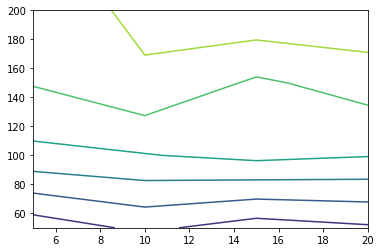

In [3]:
plt.contour(units,batch,u_b_acc)

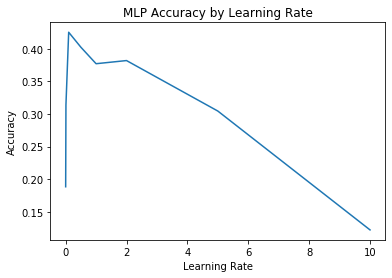

In [14]:
plt.plot(learn, learn_acc, label='accuracy')
plt.xlabel('Learning Rate')
#plt.xscale('log')
plt.ylabel('Accuracy')
#plt.ylim([-1, 1])
plt.title('MLP Accuracy by Learning Rate')
plt.savefig('mlp_learn.png', dpi = 300)


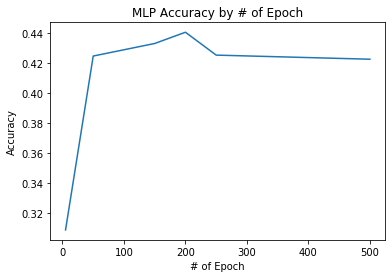

In [15]:
plt.plot(eps, ep_acc, label='accuracy')
plt.xlabel('# of Epoch')
#plt.xscale('log')
plt.ylabel('Accuracy')
#plt.ylim([-1, 1])
plt.title('MLP Accuracy by # of Epoch')
plt.savefig('mlp_epoch.png', dpi = 300)

### testing on test data

In [11]:
model = MLP(20)
model.train(X_train_new, y_train_new, lr=0.1, batch_size=200, epochs=200)

Epoch 1: training loss = 2.1627806848796443
Epoch 2: training loss = 2.0053514336020797
Epoch 3: training loss = 1.9311338239092486
Epoch 4: training loss = 1.8867377800997278
Epoch 5: training loss = 1.8491056729172826
Epoch 6: training loss = 1.8181581356555145
Epoch 7: training loss = 1.7943236564509168
Epoch 8: training loss = 1.7754249461164153
Epoch 9: training loss = 1.759438326864954
Epoch 10: training loss = 1.745034417750136
Epoch 11: training loss = 1.731583115955896
Epoch 12: training loss = 1.7190018038617259
Epoch 13: training loss = 1.7072295011871153
Epoch 14: training loss = 1.696128645120725
Epoch 15: training loss = 1.6855715275520189
Epoch 16: training loss = 1.675526007706551
Epoch 17: training loss = 1.6659306972222065
Epoch 18: training loss = 1.6567475910139595
Epoch 19: training loss = 1.6479760431773525
Epoch 20: training loss = 1.6396461387146757
Epoch 21: training loss = 1.6318303179251732
Epoch 22: training loss = 1.6245790065756072
Epoch 23: training loss 

Epoch 183: training loss = 1.3867461226958757
Epoch 184: training loss = 1.3863246599295045
Epoch 185: training loss = 1.3859024380740288
Epoch 186: training loss = 1.3854796111973675
Epoch 187: training loss = 1.3850563375494636
Epoch 188: training loss = 1.3846327786124129
Epoch 189: training loss = 1.3842090981937212
Epoch 190: training loss = 1.3837854615634175
Epoch 191: training loss = 1.3833620346355766
Epoch 192: training loss = 1.3829389831946954
Epoch 193: training loss = 1.3825164721668999
Epoch 194: training loss = 1.3820946649353338
Epoch 195: training loss = 1.3816737226981413
Epoch 196: training loss = 1.381253803866433
Epoch 197: training loss = 1.3808350634984141
Epoch 198: training loss = 1.3804176527647578
Epoch 199: training loss = 1.380001718439249
Epoch 200: training loss = 1.3795874024080106


In [12]:
accuracy = model.test(X_test_new, y_test_new)
accuracy

0.4512

In [9]:
# using 2 hidden layers
model2 = MLP_2H(20,5)
model2.train(X_train_new, y_train_new, lr=0.1, batch_size=200, epochs=200)

Epoch 1: training loss = 2.302753400424694
Epoch 2: training loss = 2.3027489176431213
Epoch 3: training loss = 2.3027426480887683
Epoch 4: training loss = 2.3027346246265727
Epoch 5: training loss = 2.302723669361062
Epoch 6: training loss = 2.302707759965785
Epoch 7: training loss = 2.302683194221513
Epoch 8: training loss = 2.3026427131056475
Epoch 9: training loss = 2.3025708225523753
Epoch 10: training loss = 2.30243042082886
Epoch 11: training loss = 2.302117923931279
Epoch 12: training loss = 2.301278156342925
Epoch 13: training loss = 2.2982631010994656
Epoch 14: training loss = 2.2820335498554387
Epoch 15: training loss = 2.203657464184275
Epoch 16: training loss = 2.1134520566090482
Epoch 17: training loss = 2.074931883679052
Epoch 18: training loss = 2.062070166927305
Epoch 19: training loss = 2.055044532793381
Epoch 20: training loss = 2.0488206388473977
Epoch 21: training loss = 2.0431432625310544
Epoch 22: training loss = 2.0369314167151304
Epoch 23: training loss = 2.030

Epoch 183: training loss = 1.466315381183783
Epoch 184: training loss = 1.4661326371677004
Epoch 185: training loss = 1.4576619765537442
Epoch 186: training loss = 1.464907677983413
Epoch 187: training loss = 1.471964943977655
Epoch 188: training loss = 1.4648761231982514
Epoch 189: training loss = 1.472527073126847
Epoch 190: training loss = 1.4905534687274564
Epoch 191: training loss = 1.5014546759398408
Epoch 192: training loss = 1.4783609540497384
Epoch 193: training loss = 1.479579045763563
Epoch 194: training loss = 1.4835571208761729
Epoch 195: training loss = 1.48029796312606
Epoch 196: training loss = 1.4678740861220292
Epoch 197: training loss = 1.4721434046703628
Epoch 198: training loss = 1.4664238842948873
Epoch 199: training loss = 1.4694575611909222
Epoch 200: training loss = 1.4631999682707273


In [10]:
accuracy = model2.test(X_test_new, y_test_new)
accuracy

0.4275